## Clustering electricity usage profiles

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Descarguemos e importemos los datos: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [2]:
import wget
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip')

'household_power_consumption.zip'

In [3]:
!unzip 'household_power_consumption.zip' -d local/data

Archive:  household_power_consumption.zip
  inflating: local/data/household_power_consumption.txt  


In [4]:
plt.style.use('seaborn')

data_path =  'local/data/household_power_consumption.txt'
cols_to_use = ['Date', 'Time','Global_active_power', 'Global_reactive_power']

df_uci = pd.read_csv(data_path, sep=';', usecols=cols_to_use, low_memory=False)
df_uci[:5]

,Date,Time,Global_active_power,Global_reactive_power
0,16/12/2006,17:24:00,4.216,0.418
1,16/12/2006,17:25:00,5.360,0.436
2,16/12/2006,17:26:00,5.374,0.498
3,16/12/2006,17:27:00,5.388,0.502
4,16/12/2006,17:28:00,3.666,0.528


In [5]:
df_uci['datetime'] = pd.to_datetime(df_uci['Date'] + ' '+ df_uci['Time'])
df_uci = df_uci.drop(['Date','Time'], axis=1)
df_uci = df_uci.set_index('datetime')

df_uci = df_uci.replace('?', np.nan)
df_uci = df_uci.astype(np.float).fillna(method='bfill')
df_uci[:5]

,Global_active_power,Global_reactive_power
datetime,,
2006-12-16 17:24:00,4.216,0.418
2006-12-16 17:25:00,5.360,0.436
2006-12-16 17:26:00,5.374,0.498
2006-12-16 17:27:00,5.388,0.502
2006-12-16 17:28:00,3.666,0.528


In [6]:
# For simplication,
# I will resample so that each row
# represents a whole hour
df_uci_hourly = df_uci.resample('H').sum()
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date
df_uci_hourly[:5]

,Global_active_power,Global_reactive_power,hour
2006-12-16,152.024,8.244,17
2006-12-16,217.932,4.802,18
2006-12-16,204.014,5.114,19
2006-12-16,196.114,4.506,20
2006-12-16,183.388,4.600,21


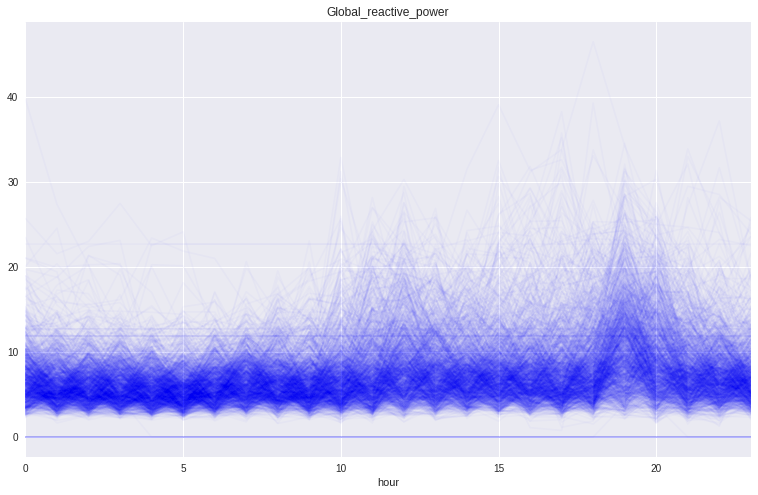

In [7]:
df_uci_pivot = df_uci_hourly.pivot(columns='hour',values='Global_reactive_power') #index='foo', columns='bar', values='baz'
df_uci_pivot = df_uci_pivot.dropna()
df_uci_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.02, title='Global_reactive_power')

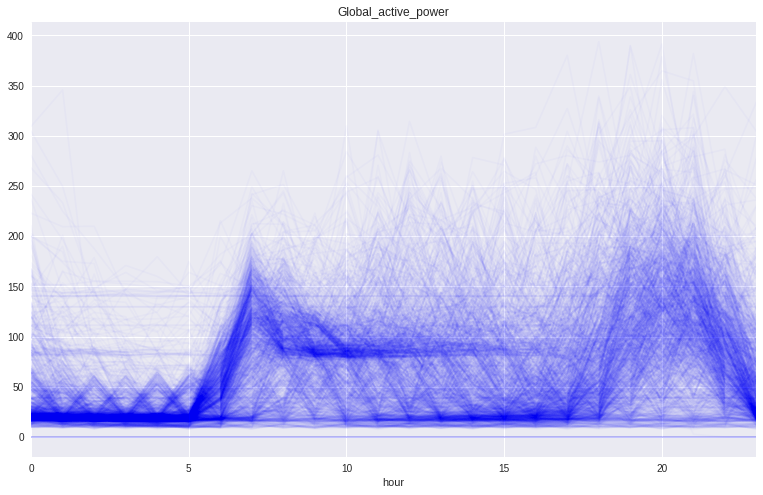

In [51]:
df_uci_pivot = df_uci_hourly.pivot(columns='hour',values='Global_active_power') #index='foo', columns='bar', values='baz'
df_uci_pivot = df_uci_pivot.dropna()
df_uci_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.02, title='Global_active_power')

In [52]:
X = df_uci_pivot.values.copy()

Text(0.5, 0, 'Usuarios')

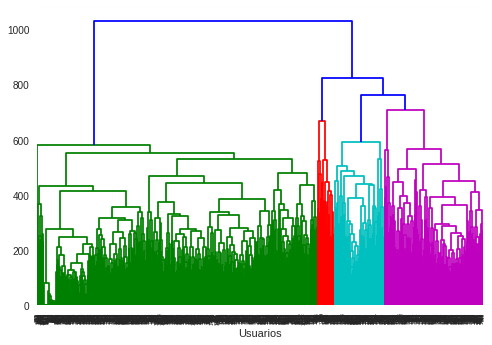

In [53]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
distxy = pdist(X, metric='euclidean')
Z = linkage(distxy, method='complete')
plt.figure()
dn = dendrogram(Z)
plt.xlabel('Usuarios')

In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

Text(0.5, 1.0, 'sillhoute coefficient')

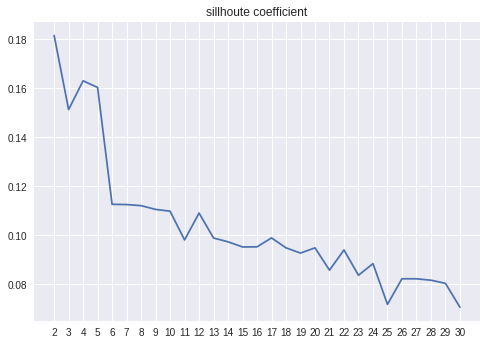

In [55]:
plt.plot(n_cluster_list,sillhoute_scores)
plt.xticks(np.arange(2,31))
plt.title('sillhoute coefficient')

Text(0.5, 0, 'hour')

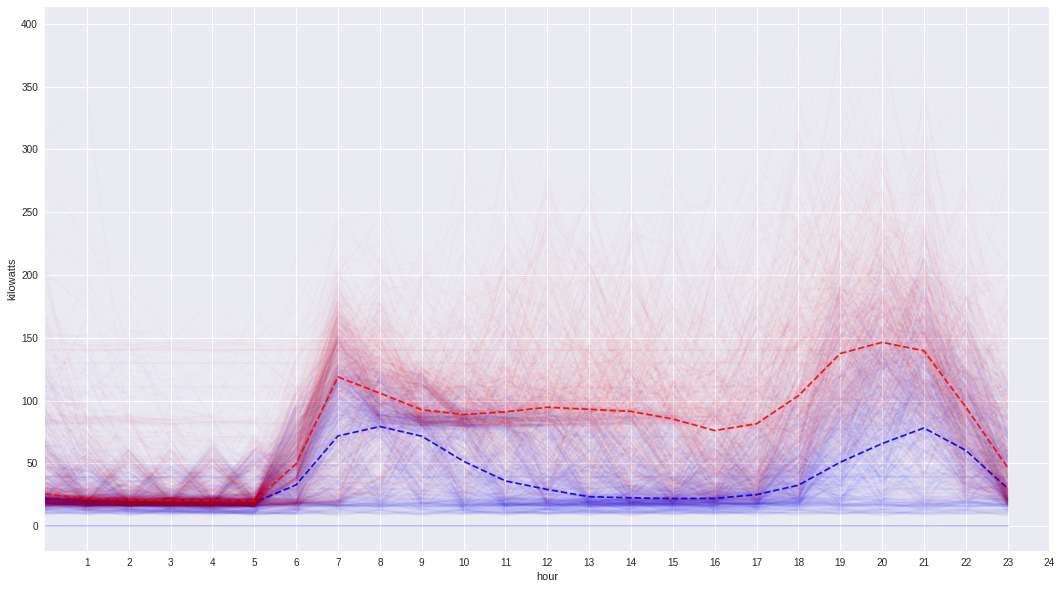

In [56]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot2 = df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot2.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot2.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot2.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
#ax.legend()

Text(0.5, 0, 'hour')

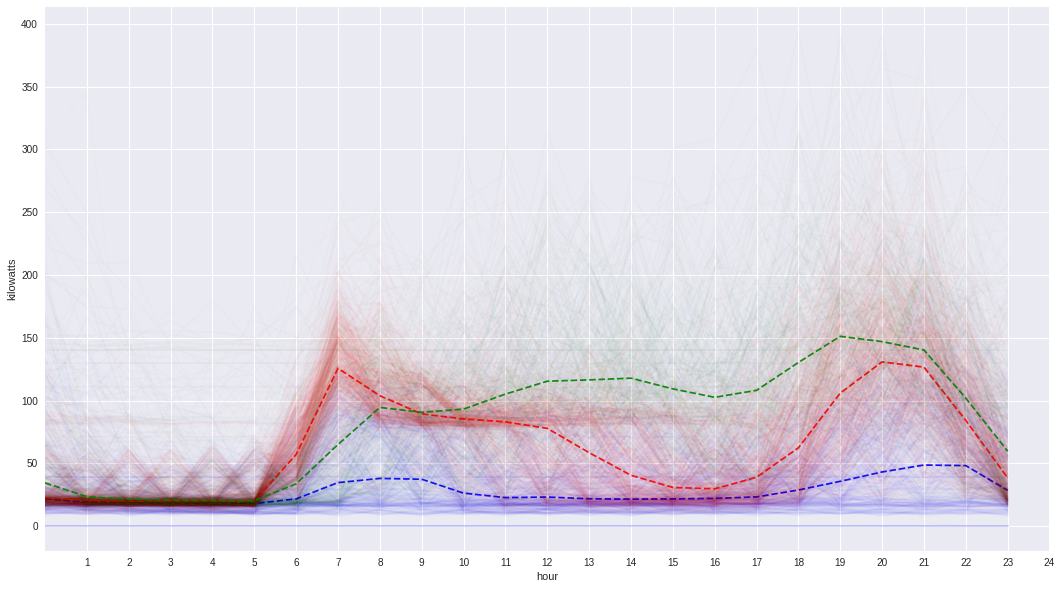

In [57]:
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
#ax.legend()

#### Ejercicio: Repetir el proceso de clustering usando GMM en lugar de k-means.

Covarianza esférica = k-means.

Text(0.5, 0, 'hour')

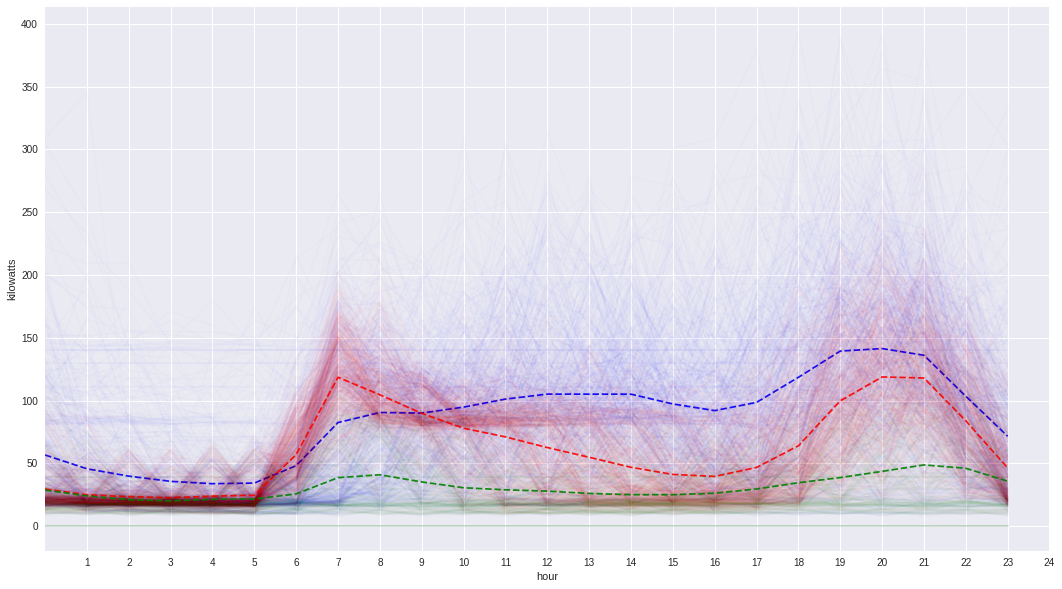

In [102]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3,covariance_type='spherical',max_iter=200)
cluster_found2 = gmm.fit_predict(X)
df_uci_pivot = df_uci_hourly.pivot(columns='hour',values='Global_active_power') #index='foo', columns='bar', values='baz'
df_uci_pivot = df_uci_pivot.dropna()
cluster_found_sr2 = pd.Series(cluster_found2, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr2, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    ax.plot(np.arange(0,24),sc.inverse_transform(gmm.means_[cluster,:].reshape(1,-1)).flatten(),color=color, alpha=0.9, ls='--')
    #df_uci_pivot.xs(cluster, level=1).median().plot(
    #    ax=ax, color=color, alpha=0.9, ls='--'
    #)

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')


#ax.legend()

Covarianza completa

Text(0.5, 0, 'hour')

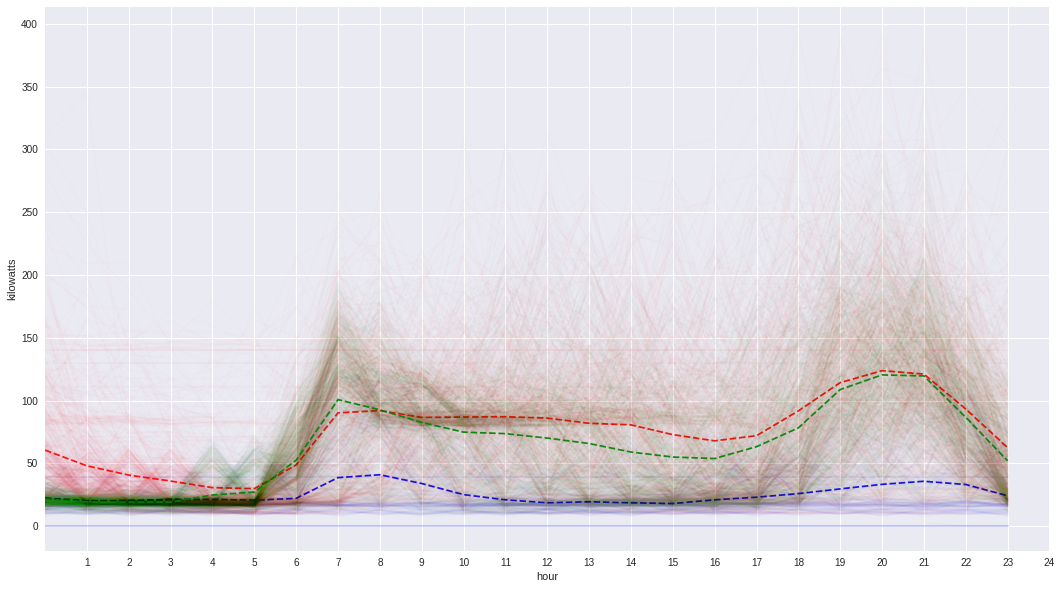

In [100]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3,covariance_type='full',max_iter=200)
cluster_found2 = gmm.fit_predict(X)
df_uci_pivot = df_uci_hourly.pivot(columns='hour',values='Global_active_power') #index='foo', columns='bar', values='baz'
df_uci_pivot = df_uci_pivot.dropna()
cluster_found_sr2 = pd.Series(cluster_found2, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr2, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    ax.plot(np.arange(0,24),sc.inverse_transform(gmm.means_[cluster,:].reshape(1,-1)).flatten(),color=color, alpha=0.9, ls='--')
    #df_uci_pivot.xs(cluster, level=1).median().plot(
    #    ax=ax, color=color, alpha=0.9, ls='--'
    #)

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')


#ax.legend()